## Dog v/s Cat Classifier

You can use this notebook to train our dog v/s cat classifier. FastAI makes it super easy to train the models too, under 10 lines of code we have a descent classifier!

In [4]:
!pip -q install fastai>-2.2.7

In [2]:
from fastai.vision.all import *
from pathlib import Path

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/annotations')]

In [7]:
files = get_image_files(path/"images")
len(files)

7390

In [5]:
from dogvscat_utils import label_func

dls = ImageDataLoaders.from_name_func(path, files, 
                                      label_func, 
                                      item_tfms=Resize(224),num_workers=0)

NameError: name 'files' is not defined

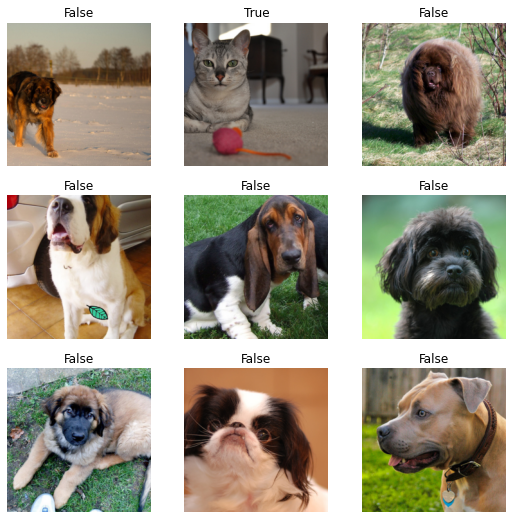

In [9]:
dls.show_batch()

As you can see we have the images ready to be loaded for training. We are going to use a resnet34 and finetune on top of that. Lets see what how it goes

In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, path='./saved_models')
learn.fine_tune(2)

epoch     train_loss  valid_loss  error_rate  time    
0         0.144637    0.199313    0.075778    01:17     
epoch     train_loss  valid_loss  error_rate  time    
0         0.055664    0.094264    0.033153    01:18     
1         0.024859    0.086211    0.023681    01:18     


In [11]:
files

(#7390) [Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/chihuahua_126.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/german_shorthaired_97.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/Bombay_157.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/Bengal_12.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/japanese_chin_116.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/havanese_109.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/scottish_terrier_122.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_146.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/boxer_176.jpg')...]

In [12]:
learn.predict(files[0])

('True', tensor(1), tensor([1.2605e-09, 1.0000e+00]))

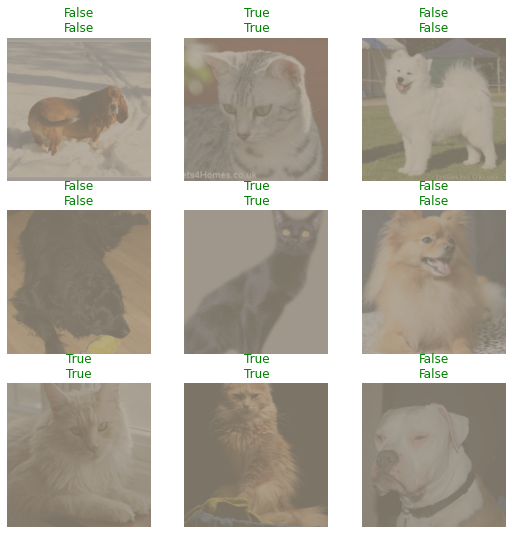

In [13]:
learn.show_results()

With just 2 epoch of training we have created a fairly descent classifier for dogs and cats, good on ya mate!

Now lets save it and generate the final model file. 

In [14]:
learn.export('model.pkl')
print('Saved to: ', learn.path)

Saved to:  saved_models


## Inference
Now lets figure out the about loading the models and running the inference. 

In [10]:
os.listdir('test_images/')

['d3.jpg', 'd2.jpg', 'd1.jpg', 'c1.jpg', 'c3.jpg', 'c2.jpg']

In [11]:
from dogvscat_utils import label_func

loaded_learner = load_learner('./saved_models/model.pkl')

In [12]:
files = get_image_files('test_images')
dl = loaded_learner.dls.test_dl(files)
dl

In [13]:
files

(#6) [Path('test_images/d3.jpg'),Path('test_images/d2.jpg'),Path('test_images/d1.jpg'),Path('test_images/c1.jpg'),Path('test_images/c3.jpg'),Path('test_images/c2.jpg')]

In [14]:
loaded_learner.get_preds(dl=dl)

(tensor([[9.9319e-01, 6.8086e-03],
         [9.9997e-01, 2.5402e-05],
         [9.9999e-01, 6.7862e-06],
         [1.7986e-08, 1.0000e+00],
         [1.9696e-13, 1.0000e+00],
         [1.0057e-13, 1.0000e+00]]), None)

In [15]:
#!pip install  -q bentoml

In [17]:
from bentoservice import DogVCatService

svc = DogVCatService()
svc.pack('learner', loaded_learner)
svc.save_to_dir('bento_service/')


[2021-03-12 13:43:52,488] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2021-03-12 13:43:52,489] WARNING - pip package requirement torch already exist
[2021-03-12 13:43:52,490] WARNING - pip package requirement fastcore already exist
[2021-03-12 13:43:52,491] WARNING - pip package requirement fastai>=2.0.0 already exist
[2021-03-12 13:43:52,897] INFO - BentoService bundle 'DogVCatService:20210312134352_060EA7' created at: bento_service/


In [28]:
saved_path = svc.save()

BentoMLException: BentoService bundle DogVCatService:20210312134352_060EA7 already registered in repository. Reset BentoService version with BentoService#set_version or bypass BentoML's model registry feature with BentoService#save_to_dir

In [6]:
!bentoml  deployment list

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
NAME    NAMESPACE    PLATFORM    BENTO_SERVICE    STATUS    AGE


In [29]:
!bentoml serve DogVCatService:20210312134352_060EA7

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
[2021-03-12 14:11:50,061] INFO - Starting BentoML API server in development mode..
[2021-03-12 14:11:51,642] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
 * Serving Flask app "DogVCatService" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to qu

In [49]:
# send file for inference
!curl -i -X  POST "http://localhost:5000/predict" \
  -F image=@d1.jpg  

curl: (26) Failed to open/read local data from file/application


In [33]:
import boto3
iam = boto3.client('iam')
role = iam.get_role(RoleName='sagemaker-mau')['Role']['Arn']
role


'arn:aws:iam::785315722499:role/sagemaker-mau'

In [32]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name rubens.mau to get Role path.


ValueError: The current AWS identity is not a role: arn:aws:iam::785315722499:user/rubens.mau, therefore it cannot be used as a SageMaker execution role

In [ ]:
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='AmazonSageMaker-ExecutionRole-20201200T100000')['Role']['Arn']

In [42]:
import boto3
iam = boto3.client('iam')
role = iam.get_role(RoleName='sagemaker-mau')['Role']['Arn']
role

'arn:aws:iam::785315722499:role/sagemaker-mau'

In [8]:
!bentoml ec2 deploy dogcats -b DogVCatService:20210312134352_060EA7


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
Error: ec2 deploy failed: INTERNAL:aws-sam-cli package is required. Install with `pip install --user aws-sam-cli`


In [7]:
!bentoml deployment list

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
NAME    NAMESPACE    PLATFORM    BENTO_SERVICE    STATUS    AGE


In [44]:
!bentoml deployment delete dogcats

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
Successfully deleted deployment "dogcats"


In [36]:
###  tem erro de privilegios 
#!bentoml sagemaker deploy dogcats -b DogVCatService:20210312134352_060EA7 --api-name predict

In [44]:
#!bentoml deployment delete dogcats


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
Successfully deleted deployment "dogcats"


In [3]:
!pwd

/home/ec2-user/mau/DogsCats


In [2]:
#url = https://runtime.sagemaker.us-east-2.amazonaws.com/endpoints/dev-dogcats/invocations
!curl -i -X  POST "http://52.14.22.14:5000:5000/predict" \
  -F image=@d1.jpg    

curl: (26) Failed to open/read local data from file/application


In [51]:
!ping runtime.sagemaker.us-east-2.amazonaws.com/endpoints/dev-dogcats/invocations

ping: unknown host runtime.sagemaker.us-east-2.amazonaws.com/endpoints/dev-dogcats/invocations
